In [ ]:
from pathlib import Path

import colorcet as cc
import h5py
import jax
import jax.numpy as jnp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import scipy
import scipy.stats as scstats
import skimage
from desmin_reconstruction.colocalization.costes import (
    colocalization_costes,
    determine_characteristic_size,
    scramble_image,
)
from desmin_reconstruction.plotting import violinplot
from desmin_reconstruction.plotting.utils import make_legend
from einops import rearrange
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm


pv.set_jupyter_backend("static")

datadir = Path("../data/SIM")


def read_SIM_data(filepath: Path | str):
    f = h5py.File(filepath)
    data = f["Data"][:]
    pixel_sizes = f["Data"].attrs["pixel_sizes"]
    dtype = data.dtype
    if dtype.kind == "u":
        data = data / np.iinfo(dtype).max
    return data, pixel_sizes


In [2]:
data, pixel_sizes = read_SIM_data(datadir / "myosin/Image20_myosin_SIM2.h5")

data.dtype

dtype('float64')

In [3]:
pixel_sizes

array([0.14412245, 0.03130297, 0.03130297], dtype=float32)

In [4]:
grid = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid.cell_data["desmin"] = np.permute_dims(data[0], (2, 1, 0)).flatten(order="F")

grid2 = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid2.cell_data["myosin"] = np.permute_dims(data[1], (2, 1, 0)).flatten(order="F")


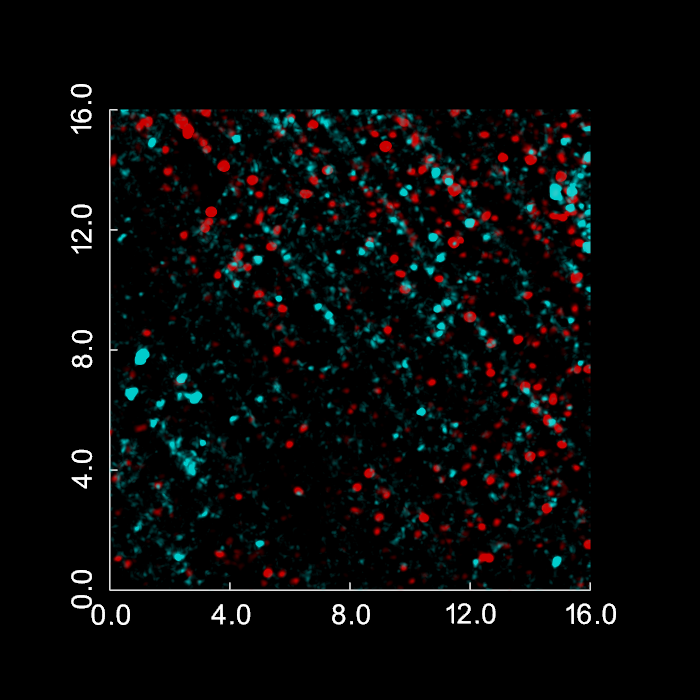

In [8]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid,
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2,
    cmap=["#00FFFF"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    axes_ranges=[0, 16, 0, 16, 0, 0],
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
pl.show()
pl.save_graphic("../figures/fig_2/2e/myosin.svg")

In [2]:
filepath_dict = {
    "myosin": "myosin/Image20_myosin_SIM2.h5",
    "actin": "actin/Image10_actin_SIM2.h5",
    "actinin": "alpha-actinin/Image2_SIM2.h5",
}
roi_dict = {
    "myosin": np.s_[:, :, :, :],
    "actin": np.s_[::-1, :, 512:1536, 512:1536],
    "actinin": np.s_[:, :, 0:1024, 1024:2048],
}
data_chunk_dict = {}
results_dict = {}

In [3]:
for protein in ("actin", "actinin", "myosin"):
    data, _ = read_SIM_data(datadir / filepath_dict[protein])
    data_chunks = rearrange(
        data[roi_dict[protein]], "C Z (Ny Y) (Nx X) -> (Ny Nx) C Z Y X", Ny=4, Nx=4
    )
    print(data_chunks.shape)
    data_chunk_dict[protein] = data_chunks

(16, 2, 45, 256, 256)
(16, 2, 45, 256, 256)
(16, 2, 39, 128, 128)


In [4]:
for protein in ("actin", "actinin", "myosin"):
    data_chunks = jnp.asarray(data_chunk_dict[protein])
    results = jax.lax.map(
        lambda args: colocalization_costes(args[0], args[1]), data_chunks, batch_size=4
    )
    print(results)
    results_dict[protein] = results
    del data_chunks

{'deming_intercept': Array([ 0.00010958,  0.00021698,  0.00036919,  0.00075196, -0.0001848 ,
        0.00075539,  0.00189522,  0.00203061,  0.00029737,  0.00162271,
        0.00073596,  0.00171836,  0.00051762,  0.00128041,  0.00127093,
       -0.00057402], dtype=float32), 'deming_slope': Array([0.869741  , 0.92786324, 0.80202585, 0.85479665, 0.9857316 ,
       0.7328832 , 0.5030884 , 0.59308636, 1.0740265 , 0.8778937 ,
       0.83262235, 0.79620063, 0.8500148 , 0.8526819 , 0.9854195 ,
       1.2184762 ], dtype=float32), 'manders_1': Array([0.6848261 , 0.6816436 , 0.66432196, 0.6994972 , 0.62713957,
       0.6061948 , 0.6259369 , 0.68453807, 0.801909  , 0.773141  ,
       0.6952859 , 0.6922155 , 0.74965286, 0.7658903 , 0.7352481 ,
       0.5944744 ], dtype=float32), 'manders_2': Array([0.7468874 , 0.72744   , 0.74495775, 0.7157524 , 0.7140094 ,
       0.70114416, 0.60721254, 0.7068963 , 0.7989215 , 0.7260686 ,
       0.67966765, 0.6714152 , 0.77087   , 0.7615758 , 0.7425666 ,
       0.

ANOVA result: F_onewayResult(statistic=np.float64(66.44929156474751), pvalue=np.float64(1.4008816387793579e-11))
Games-Howell result: [[1.00000000e+00 6.97952118e-08 4.76396700e-12]
 [6.97952118e-08 1.00000000e+00 1.65473454e-05]
 [4.76396700e-12 1.65473454e-05 1.00000000e+00]]


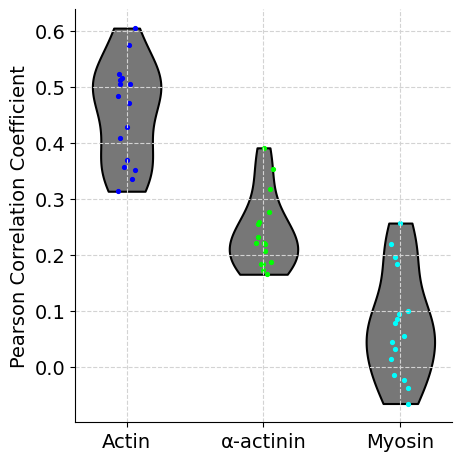

In [5]:
plt.rc("font", size=14)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), constrained_layout=True)
pearsons = [
    np.asarray(results_dict[k]["pearson"]) for k in ("actin", "actinin", "myosin")
]

COLORS = ("#0000FF", "#00FF00", "#00FFFF")

parts = ax.violinplot(pearsons, showmeans=False, showmedians=False, showextrema=False)


for c, pc in zip(COLORS, parts["bodies"]):
    pc.set_edgecolor("black")
    pc.set_facecolor("#777777")
    pc.set_alpha(1.0)
    pc.set_linewidth(1.5)

eps = 0.07
rng = np.random.default_rng(11)
for i, (c, p) in enumerate(zip(COLORS, pearsons)):
    x = i + 1 + rng.uniform(-eps, eps, len(p))
    ax.scatter(x, p, s=30, color=c, marker=".")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(ticks=[1, 2, 3], labels=["Actin", "α-actinin", "Myosin"])
ax.grid(ls="--", color="lightgray")
ax.set_ylabel("Pearson Correlation Coefficient")
# fig.savefig("../figures/fig_2/2e/pearson.svg", dpi=500)

print(f"ANOVA result: {scstats.f_oneway(*pearsons, equal_var=False)}")
print(f"Games-Howell result: {scstats.tukey_hsd(*pearsons, equal_var=False).pvalue}")

ANOVA result: F_onewayResult(statistic=np.float64(301.3005260190376), pvalue=np.float64(9.590090576649708e-20))
Games-Howell result: [[1.00000000e+00 1.56957056e-05 0.00000000e+00]
 [1.56957056e-05 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


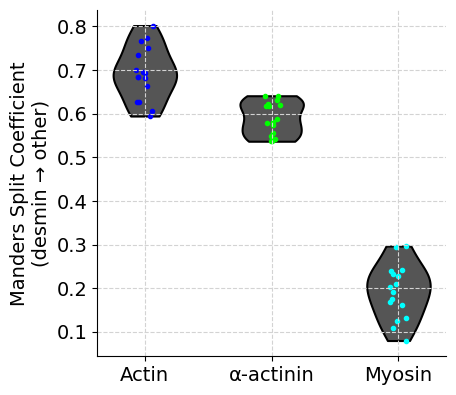

In [11]:
plt.rc("font", size=14)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
manders_1 = [
    np.asarray(results_dict[k]["manders_1"]) for k in ("actin", "actinin", "myosin")
]
parts = ax.violinplot(manders_1, showmeans=False, showmedians=False, showextrema=False)
ax.set_xticks(ticks=[1, 2, 3], labels=["Actin", "α-actinin", "Myosin"])
COLORS = ("#0000FF", "#00FF00", "#00FFFF")
for c, pc in zip(COLORS, parts["bodies"]):
    pc.set_edgecolor("black")
    pc.set_facecolor("#555555")
    pc.set_alpha(1.0)
    pc.set_linewidth(1.5)

eps = 0.07
rng = np.random.default_rng(11)
for i, (c, p) in enumerate(zip(COLORS, manders_1)):
    x = i + 1 + rng.uniform(-eps, eps, len(p))
    ax.scatter(x, p, s=9, color=c)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_ylabel("Manders Split Coefficient\n(desmin → other)")

print(f"ANOVA result: {scstats.f_oneway(*manders_1, equal_var=False)}")
print(f"Games-Howell result: {scstats.tukey_hsd(*manders_1, equal_var=False).pvalue}")

ANOVA result: F_onewayResult(statistic=np.float64(651.4222068682781), pvalue=np.float64(2.5484895955653803e-25))
Games-Howell result: [[1.00000000e+00 1.05512281e-08 2.22044605e-15]
 [1.05512281e-08 1.00000000e+00 8.88178420e-16]
 [2.22044605e-15 8.88178420e-16 1.00000000e+00]]


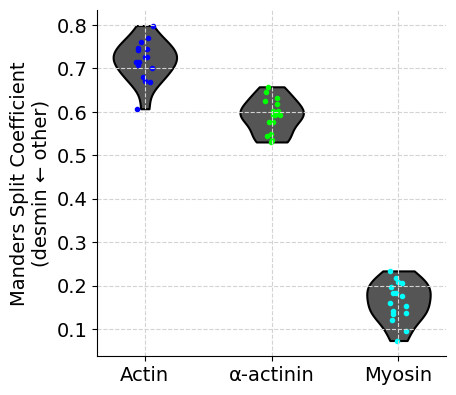

In [12]:
plt.rc("font", size=14)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
manders_2 = [
    np.asarray(results_dict[k]["manders_2"]) for k in ("actin", "actinin", "myosin")
]
parts = ax.violinplot(manders_2, showmeans=False, showmedians=False, showextrema=False)
ax.set_xticks(ticks=[1, 2, 3], labels=["Actin", "α-actinin", "Myosin"])
COLORS = ("#0000FF", "#00FF00", "#00FFFF")
for c, pc in zip(COLORS, parts["bodies"]):
    pc.set_edgecolor("black")
    pc.set_facecolor("#555555")
    pc.set_alpha(1.0)
    pc.set_linewidth(1.5)

eps = 0.07
rng = np.random.default_rng(11)
for i, (c, p) in enumerate(zip(COLORS, manders_2)):
    x = i + 1 + rng.uniform(-eps, eps, len(p))
    ax.scatter(x, p, s=9, color=c)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_ylabel("Manders Split Coefficient\n(desmin ← other)")

print(f"ANOVA result: {scstats.f_oneway(*manders_2, equal_var=False)}")
print(f"Games-Howell result: {scstats.tukey_hsd(*manders_2, equal_var=False).pvalue}")

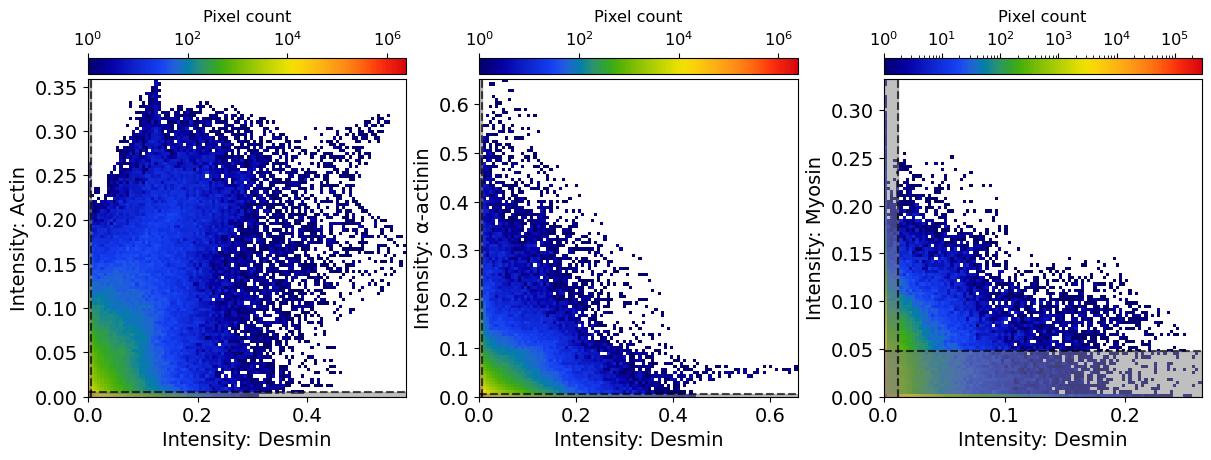

In [6]:
name_dict = {"actin": "Actin", "actinin": "α-actinin", "myosin": "Myosin"}

fig, axes = plt.subplots(
    1, 3, figsize=(12, 4), constrained_layout=True, gridspec_kw={"hspace": 0.3}
)
chunk_idx = 0
for k, ax in zip(("actin", "actinin", "myosin"), axes):
    h = ax.hist2d(
        data_chunk_dict[k][chunk_idx, 0].flatten(),
        data_chunk_dict[k][chunk_idx, 1].flatten(),
        bins=100,
        norm=mcolors.LogNorm(),
        cmap=cc.cm.rainbow4,
    )
    t, a, b = (
        results_dict[k]["threshold"][chunk_idx],
        results_dict[k]["deming_slope"][chunk_idx],
        results_dict[k]["deming_intercept"][chunk_idx],
    )
    ax.axvline(t, ls="--", color="black", alpha=0.7)
    ax.axhline(a * t + b, ls="--", color="black", alpha=0.7)
    ax.axvspan(0, t, color="gray", alpha=0.5)
    ax.axhspan(0, a * t + b, color="gray", alpha=0.5)
    ax.set_ylabel(f"Intensity: {name_dict[k]}")
    ax.set_xlabel("Intensity: Desmin")

    # ax.set_aspect("equal", "box")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    ax.figure.colorbar(h[-1], cax=cax, orientation="horizontal")
    cax.tick_params(labelsize="small")
    cax.set_title("Pixel count", fontsize="small")
    cax.xaxis.set_label_position("top")
    cax.xaxis.set_ticks_position("top")
# fig.savefig(
#     "../figures/fig_2/2e/intensity_histograms.svg", dpi=500, bbox_inches="tight"
# )

[11 23 19]
[ 5 11 21]
[13 11  7]


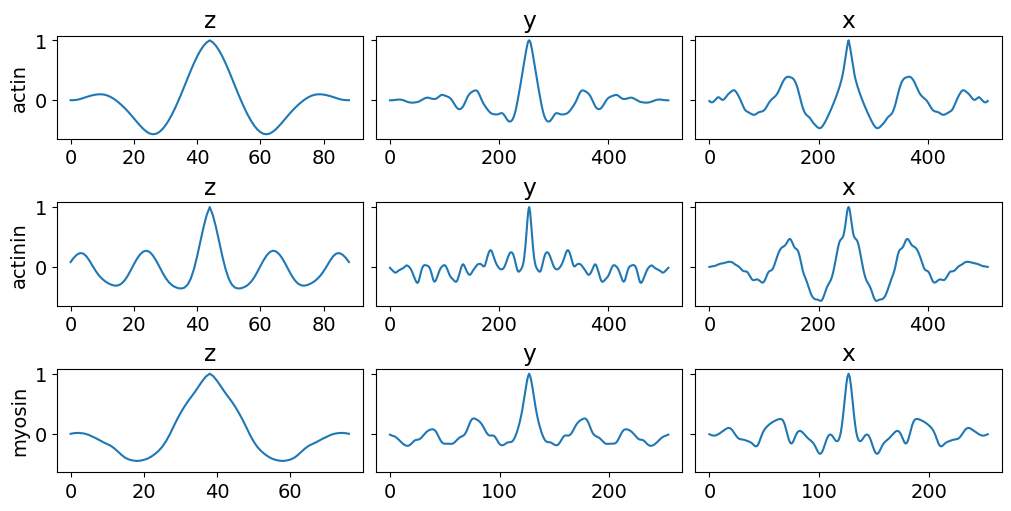

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(10, 5), constrained_layout=True, sharey=True)
for axes_row, protein in zip(axes, ("actin", "actinin", "myosin")):
    sizes, autocorrelations = determine_characteristic_size(
        data_chunk_dict[protein][chunk_idx, 0]
    )
    print(sizes)
    for autocorr, ax, t in zip(autocorrelations, axes_row, ("z", "y", "x")):
        ax.plot(autocorr)
        ax.set_title(t)
    axes_row[0].set_ylabel(protein)

In [11]:
chunk_size

(11, 23, 19)

In [48]:
keys = jax.random.split(jax.random.key(0), 200)
chunk_scrambled = jax.vmap(scramble_image, in_axes=(None, None, 0))(
    data_chunks[0, 0], chunk_size, keys
)


In [ ]:
chunk_scrambled.shape

(500, 45, 256, 256)

In [49]:
results_actin_scrambled = jax.lax.map(
    lambda args: colocalization_costes(args, data_chunks[0, 1]),
    chunk_scrambled,
    batch_size=1,
)

In [50]:
pearson_scrambled = np.asarray(results_actin_scrambled["pearson"])

In [7]:
def step(chunk, key, *, n_bootstrap: int):
    chunk = jnp.asarray(chunk)
    chunk_size = determine_characteristic_size(chunk[0])
    chunk_size = tuple(int(s) for s in chunk_size[0])
    keys = jax.random.split(key, n_bootstrap)

    chunk_scrambled = jax.vmap(scramble_image, in_axes=(None, None, 0))(
        chunk[0], chunk_size, keys
    )
    res = jax.lax.map(
        lambda args: colocalization_costes(args, chunk[1]),
        chunk_scrambled,
        batch_size=3,
    )
    return res["pearson"]


pearsons_scrambled_dict = {}
for protein in ("actin", "actinin", "myosin"):
    data_chunks = data_chunk_dict[protein]
    pearsons = np.asarray(
        [
            step(data_chunks[i], jax.random.key(i), n_bootstrap=200)
            for i in tqdm(range(data_chunks.shape[0]))
        ]
    )
    pearsons_scrambled_dict[protein] = np.nan_to_num(pearsons)


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:12<00:00,  4.53s/it]


In [11]:
pearsons_scrambled_dict["actin"].shape

(16, 200)

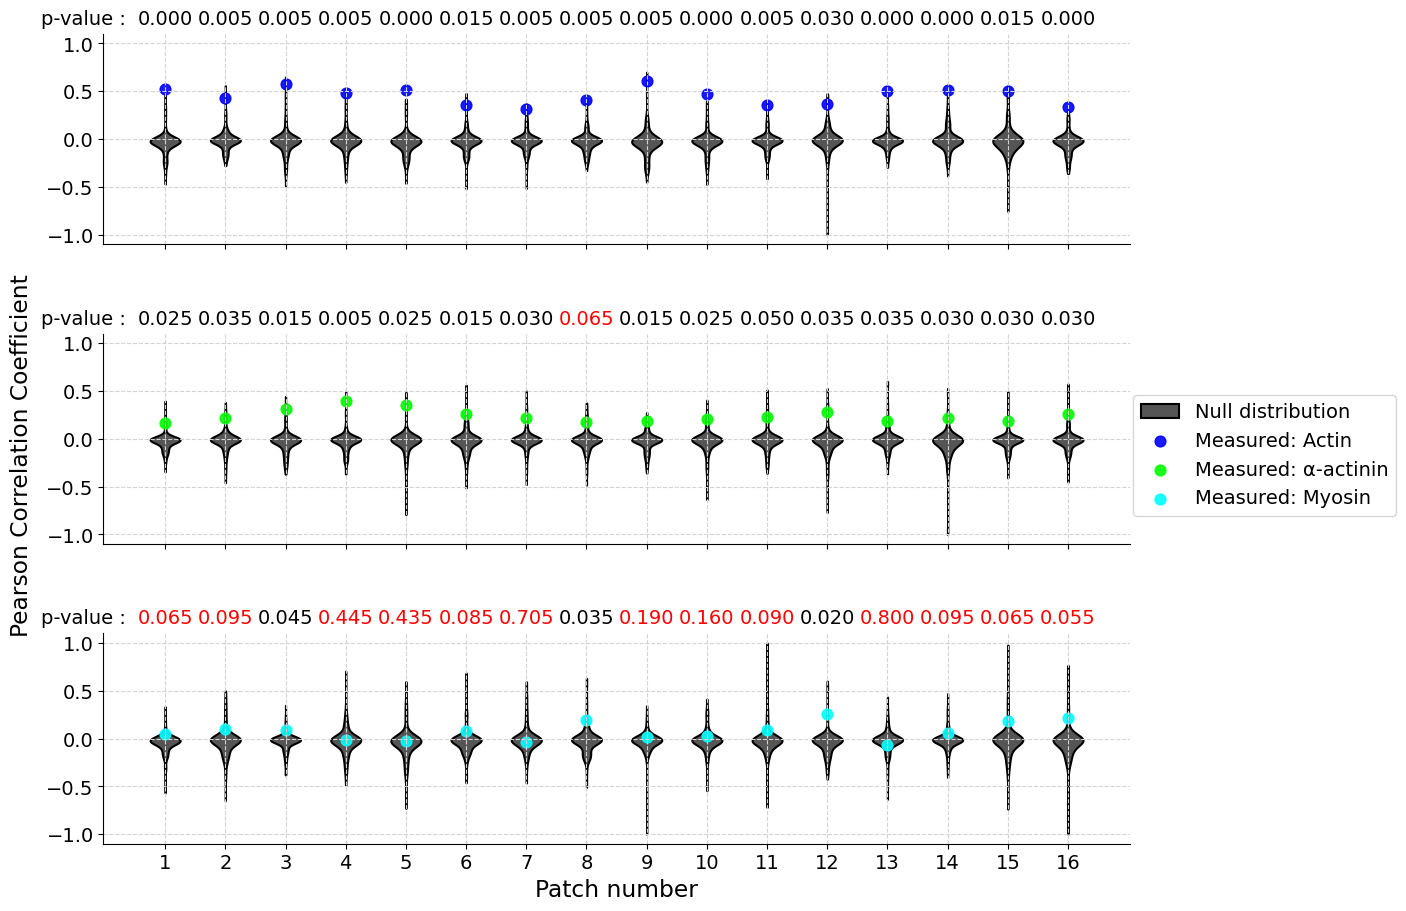

In [ ]:
COLOR_DICT = {"actin": "#0000FF", "actinin": "#00FF00", "myosin": "#00FFFF"}
LABEL_DICT = {"actin": "Actin", "actinin": "α-actinin", "myosin": "Myosin"}

fig, axes = plt.subplots(
    3,
    1,
    figsize=(14, 9),
    constrained_layout=True,
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.2},
)
for ax, protein in zip(axes, ("actin", "actinin", "myosin")):
    pearson_scrambled = pearsons_scrambled_dict[protein]
    pearson_measured = results_dict[protein]["pearson"]
    ax, handles_labels = violinplot(
        ax,
        pearson_scrambled,
        facecolor="#555555",
        linewidth=1.5,
        label="Null distribution",
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )
    ax.scatter(
        np.arange(1, 1 + len(pearson_measured)),
        pearson_measured,
        color=COLOR_DICT[protein],
        s=60,
        marker="o",
        alpha=0.9,
        label=f"Measured: {LABEL_DICT[protein]}",
    )

    p_vals = np.mean(
        pearson_scrambled > pearson_measured.reshape(-1, 1),
        axis=-1,
    )
    for i, p_i in enumerate(p_vals):
        color = "black" if p_i < 0.05 else "red"
        ax.text(i + 1, 1.2, f"{p_i:.3f}", ha="center", fontsize="medium", color=color)
    ax.text(-0.3, 1.2, "p-value : ", ha="center", fontsize="medium")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")

make_legend(
    axes[-1],
    [handles_labels] + [ax.get_legend_handles_labels() for ax in axes],
    loc="outside center right",
)
axes[-1].set_xlabel("Patch number", fontsize="large")
fig.supylabel("Pearson Correlation Coefficient")

# fig.savefig("../figures/supp_fig_3.svg", dpi=500)

In [ ]:
# np.savez("../data/results/pearson_scrambled.npz", **pearsons_scrambled_dict)

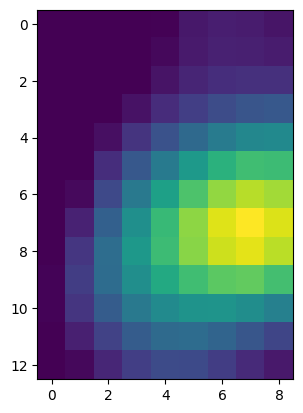

In [13]:
plt.imshow(data[0][: sizes[0], 3 : 3 + sizes[1], 200])

In [ ]:
pixel_sizes

array([0.14412245, 0.03130297, 0.03130297], dtype=float32)

In [ ]:
mip = np.max(data, axis=1)
mip.shape

(2, 512, 512)

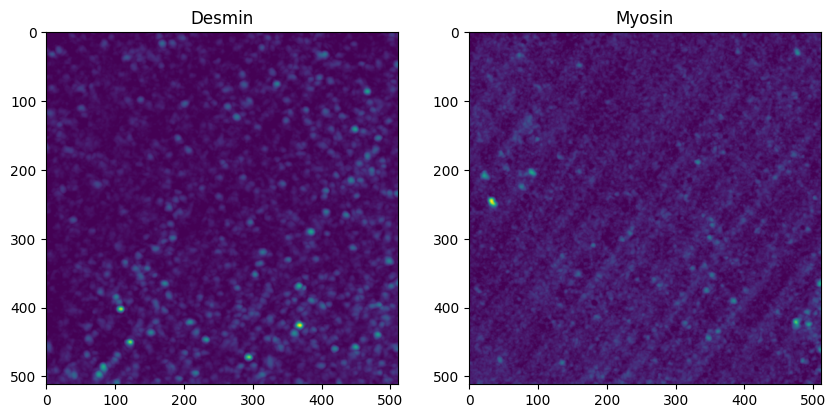

In [ ]:
from matplotlib.colors import ListedColormap


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    # ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.imshow(mip[i], cmap=ListedColormap(["#FF0000"]), alpha=mip[i])
    ax.set_title(name)

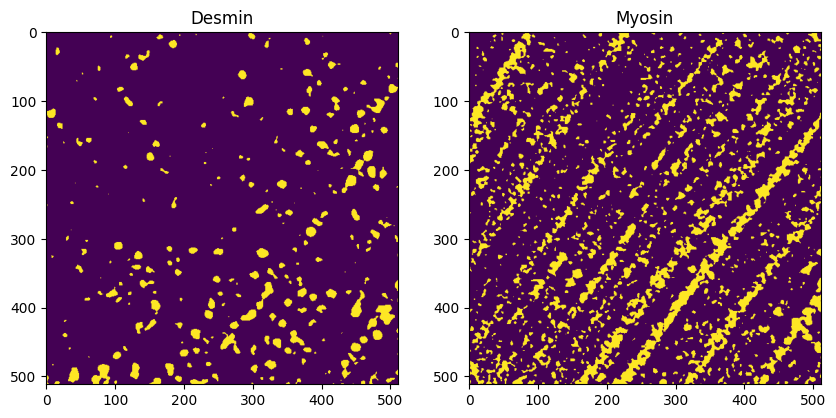

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    img = data[i, 20]
    binarized = img > skimage.filters.threshold_otsu(img)
    ax.imshow(binarized)
    ax.set_title(name)

In [10]:
data[0].shape

(39, 512, 512)

In [ ]:
import jax
import jax.numpy as jnp


img = jnp.asarray(data[0, :, 0:128, 0:128])
sizes_tuple = tuple(s.item() for s in sizes)
key = jax.random.key(0)

In [14]:
%%timeit
img_scrambled = scramble_image(img, sizes_tuple, key).block_until_ready()

110 μs ± 865 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


NameError: name 'pearson_r' is not defined

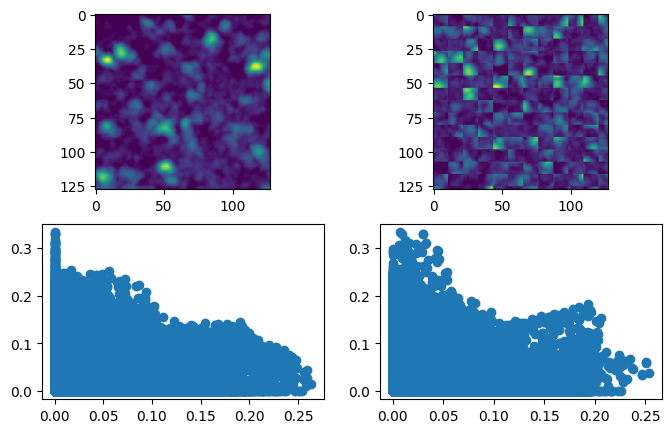

In [ ]:
img = data[0, :, 0:128, 0:128]
sizes, autocorrs = determine_characteristic_size(data[0, :, 0:128, 0:128])
img_scrambled = scramble_image(img, sizes_tuple, key)

fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes[0, 0].imshow(np.max(img, axis=0))
axes[0, 1].imshow(np.max(img_scrambled, axis=0))

axes[1, 0].scatter(
    data[0, :, 0:128, 0:128].flatten(), data[1, :, 0:128, 0:128].flatten()
)
axes[1, 1].scatter(img_scrambled.flatten(), data[1, :, 0:128, 0:128].flatten())
print(pearson_r(data[0, :, 0:128, 0:128].flatten(), data[1, :, 0:128, 0:128].flatten()))
print(pearson_r(img_scrambled.flatten(), data[1, :, 0:128, 0:128].flatten()))

Text(0.6174999999999999, 0.5850000000000001, '$r=-0.1554$')

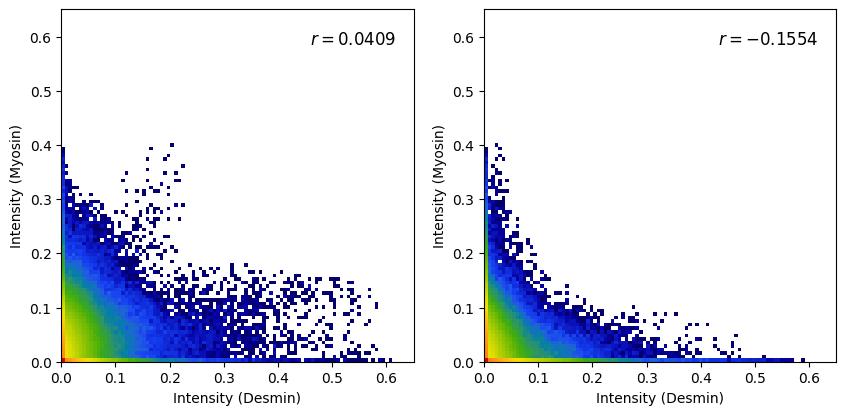

In [119]:
def pearson_correlation_coefficient(channel_1, channel_2):
    threshold_1 = skimage.filters.threshold_otsu(channel_1)
    threshold_2 = skimage.filters.threshold_otsu(channel_2)

    mask = np.logical_and(channel_1 >= threshold_1, channel_2 >= threshold_2)
    return scipy.stats.pearsonr(channel_1[mask], channel_2[mask]), (
        threshold_1,
        threshold_2,
    )


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
range_max = 0.65

corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])
h = axes[0].hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
axes[0].set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")

axes[0].set_xlabel("Intensity (Desmin)")
axes[0].set_ylabel("Intensity (Myosin)")
axes[0].text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

corrcoef, thresholds = pearson_correlation_coefficient(
    img_resampled[*roi], data[1, *roi]
)
h = axes[1].hist2d(
    img_resampled[*roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
axes[1].set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")

axes[1].set_xlabel("Intensity (Desmin)")
axes[1].set_ylabel("Intensity (Myosin)")
axes[1].text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

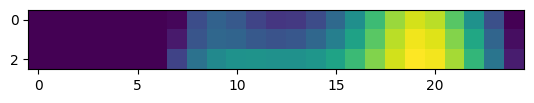

In [74]:
plt.imshow(data[0][:fwhm_z, :fwhm_y, 200])

In [ ]:
autocorr_x = np.mean(out, axis=(1, 2))
autocorr_x = autocorr_x / np.max(autocorr_x)
print(f"FWHM x: {np.sum(autocorr_x - 0.5 >= 0)}")
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(autocorr_x)


np.int64(7)

In [57]:
stuff = np.mean(out, axis=(1, 2))
stuff[0]

np.float64(-0.15762514497912172)

In [60]:
stuff - stuff[::-1]

array([ 1.11022302e-16,  2.77555756e-17,  1.66533454e-16, -2.22044605e-16,
        1.11022302e-16,  5.55111512e-16,  1.72084569e-15, -7.21644966e-16,
        1.22124533e-15, -2.22044605e-16,  2.41473508e-15, -4.16333634e-16,
        2.44249065e-15,  1.26287869e-15,  4.14598911e-16, -1.11022302e-15,
       -5.96744876e-16,  4.99600361e-16, -1.54043445e-15, -5.82867088e-16,
       -1.80411242e-16,  1.32706346e-15,  7.63278329e-16,  1.05471187e-15,
        4.57966998e-16,  2.06779038e-15, -1.30451205e-15,  8.11850587e-16,
        9.80118764e-16, -1.53349555e-15,  2.75474088e-15, -7.91033905e-16,
       -7.35522754e-15,  2.22044605e-16,  2.22044605e-16, -1.66533454e-15,
       -2.22044605e-16,  4.44089210e-15,  0.00000000e+00, -4.44089210e-15,
        2.22044605e-16,  1.66533454e-15, -2.22044605e-16, -2.22044605e-16,
        7.35522754e-15,  7.91033905e-16, -2.75474088e-15,  1.53349555e-15,
       -9.80118764e-16, -8.11850587e-16,  1.30451205e-15, -2.06779038e-15,
       -4.57966998e-16, -

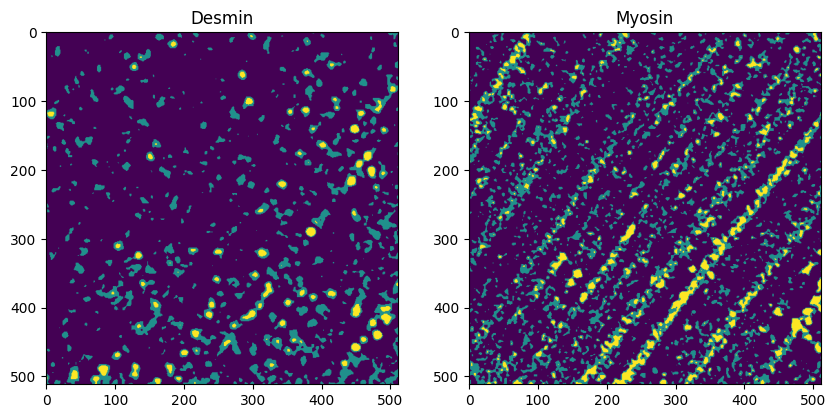

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Myosin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    img = data[i, 20]
    thresholds = skimage.filters.threshold_multiotsu(img)
    ax.imshow(np.digitize(img, bins=thresholds))
    ax.set_title(name)

(0.0, 0.2)

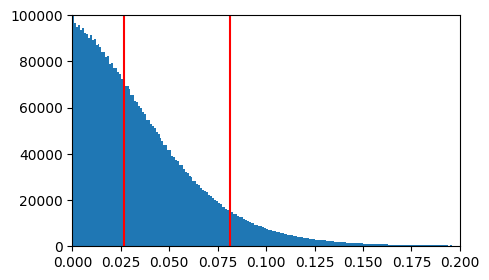

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(data[1].flatten(), bins=1000)
ax.axvline(thresholds[0], color="red")
ax.axvline(thresholds[1], color="red")
ax.set_ylim((0, 100000))
ax.set_xlim((0, 0.2))

In [30]:
def pearson_correlation_coefficient(channel_1, channel_2):
    threshold_1 = skimage.filters.threshold_otsu(channel_1)
    threshold_2 = skimage.filters.threshold_otsu(channel_2)

    mask = np.logical_and(channel_1 >= threshold_1, channel_2 >= threshold_2)
    return scipy.stats.pearsonr(channel_1[mask], channel_2[mask]), (
        threshold_1,
        threshold_2,
    )


corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])

In [31]:
corrcoef.statistic

np.float64(0.04087356408293242)

Text(0.6174999999999999, 0.5850000000000001, '$r=0.0409$')

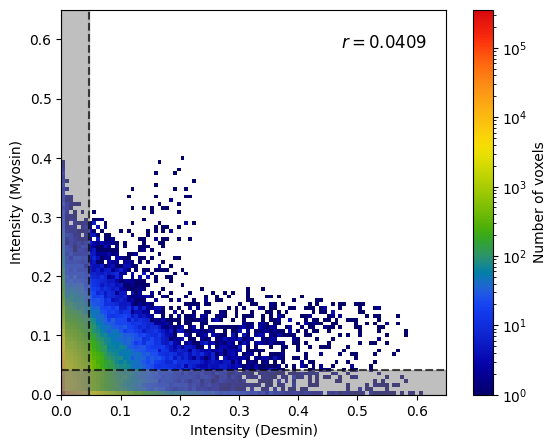

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Myosin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

In [9]:
data, pixel_sizes = read_SIM_data(datadir / "actin/Image10_actin_SIM2.h5")
roi = (slice(10, 33), slice(1200, 1600), slice(200, 600))

In [13]:
data.shape

(2, 45, 2048, 2048)

In [14]:
pixel_sizes

array([0.12593877, 0.01565149, 0.01565149], dtype=float32)

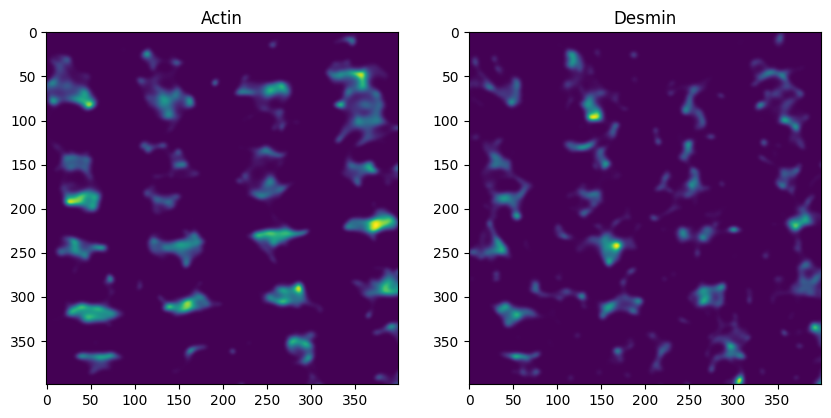

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Actin", "Desmin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.set_title(name)

In [10]:
grid = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid.cell_data["desmin"] = np.permute_dims(data[1], (2, 1, 0)).flatten(order="F")

grid2 = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid2.cell_data["actin"] = np.permute_dims(data[0], (2, 1, 0)).flatten(order="F")

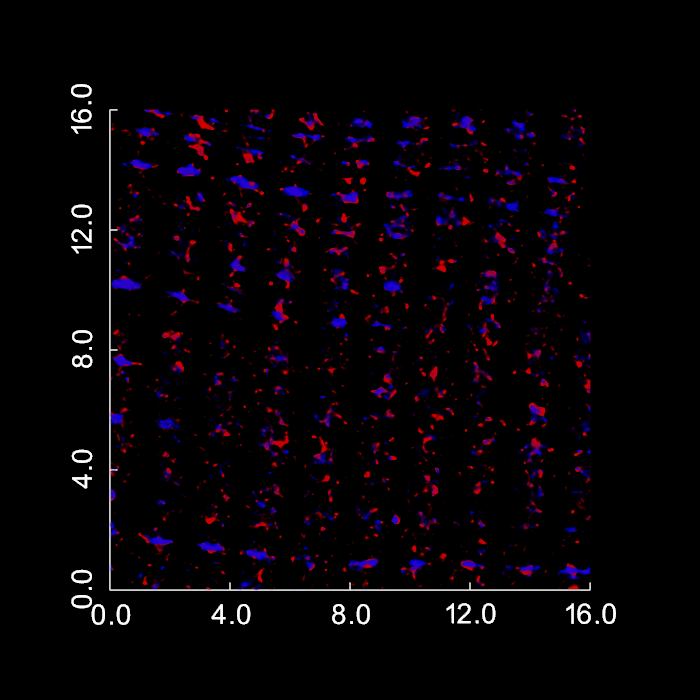

In [11]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid.extract_subset([512, 1536, 512, 1536, 0, 45]),
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2.extract_subset([512, 1536, 512, 1536, 0, 45]),
    cmap=["#0000FF"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    axes_ranges=[0, 16, 0, 16, 0, 0],
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
pl.show()
pl.save_graphic("../figures/fig_2/2e/actin.svg")

In [37]:
corrcoef, thresholds = pearson_correlation_coefficient(data[1, *roi], data[0, *roi])

Text(0.6174999999999999, 0.5850000000000001, '$r=0.2458$')

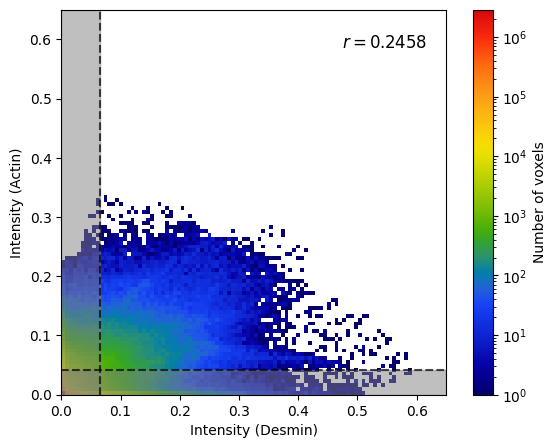

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[1, *roi].flatten(),
    data[0, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Actin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)

In [12]:
data, pixel_sizes = read_SIM_data(datadir / "alpha-actinin/Image2_SIM2.h5")
roi = (slice(10, 33), slice(200, 600), slice(1000, 1400))

In [34]:
data.shape

(2, 45, 2048, 2048)

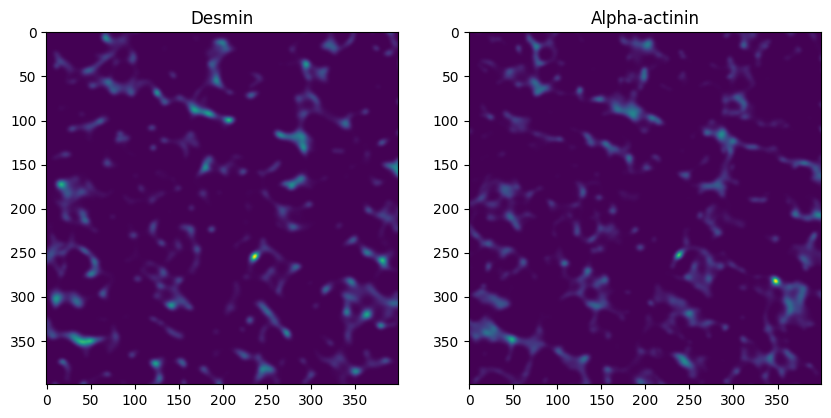

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (ax, name) in enumerate(zip(axes, ("Desmin", "Alpha-actinin"))):
    # ax.imshow(np.mean(actin[i, :, 200:1200, 1000:2000], axis=0))
    ax.imshow(np.mean(data[i, *roi], axis=0))
    ax.set_title(name)

In [13]:
grid = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid.cell_data["desmin"] = np.permute_dims(data[0], (2, 1, 0)).flatten(order="F")

grid2 = pv.ImageData(
    dimensions=np.array(data[0].shape[::-1]) + 1, spacing=pixel_sizes[::-1]
)
grid2.cell_data["alpha-actinin"] = np.permute_dims(data[1], (2, 1, 0)).flatten(
    order="F"
)


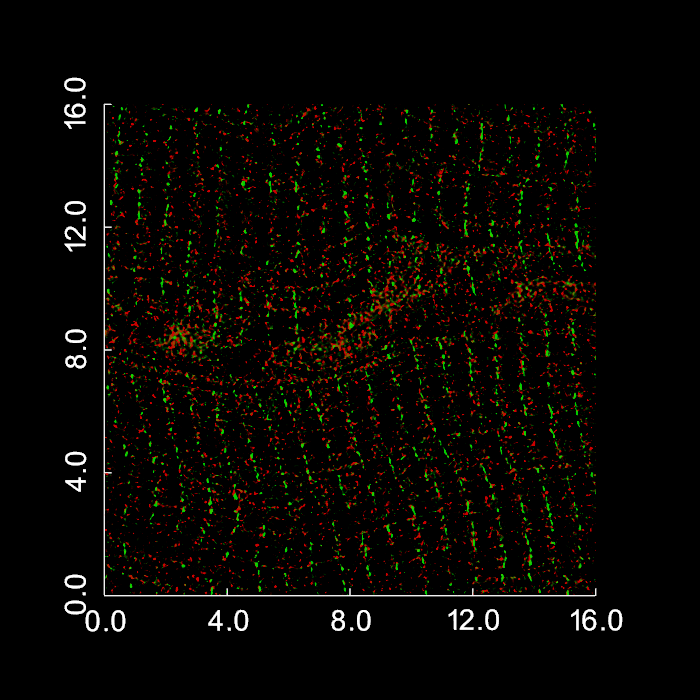

In [ ]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid,
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2,
    cmap=["#00FF00"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
pl.show()


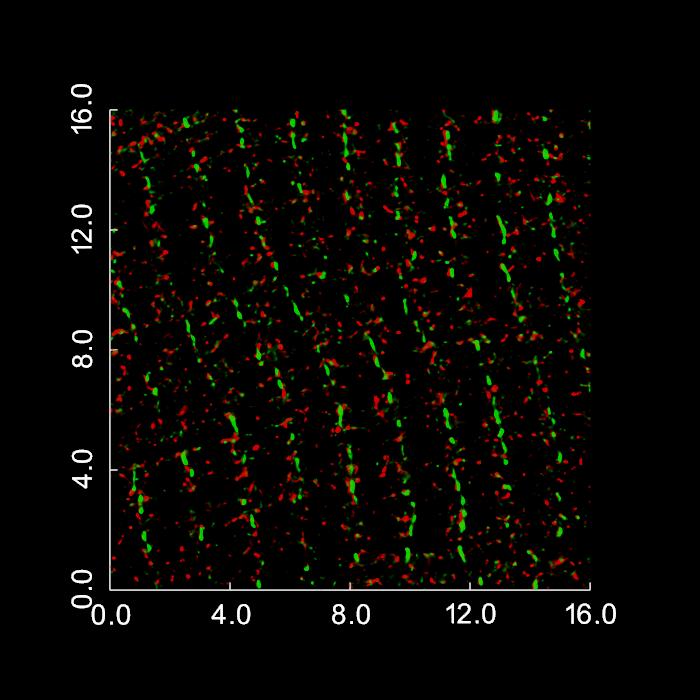

In [16]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_volume(
    grid.extract_subset([1024, 2048, 0, 1024, 0, 45]),
    cmap=["#FF0000"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
actor = pl.add_volume(
    grid2.extract_subset([1024, 2048, 0, 1024, 0, 45]),
    cmap=["#00FF00"],
    opacity=[0.0, 0.1, 0.8],
    clim=(0, 0.2),
    # opacity_unit_distance=1.5,
    blending="maximum",
    show_scalar_bar=False,
)
actor.prop.interpolation_type = "linear"
pl.set_background(color="black")
pl.enable_parallel_projection()

pl.view_xy()
axis = pl.show_bounds(
    color="white",
    axes_ranges=[0, 16, 0, 16, 0, 0],
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
pl.show()
pl.save_graphic("../figures/fig_2/2e/actinin.svg")

In [41]:
corrcoef, thresholds = pearson_correlation_coefficient(*data[:, *roi])

Text(0.6174999999999999, 0.5850000000000001, '$r=0.1666$')

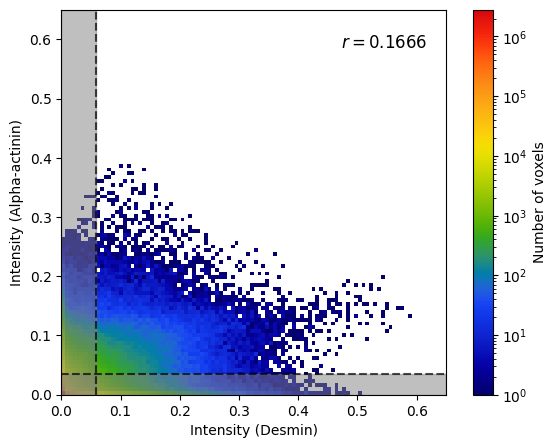

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
range_max = 0.65
h = ax.hist2d(
    data[0, *roi].flatten(),
    data[1, *roi].flatten(),
    bins=100,
    range=[[0, range_max], [0, range_max]],
    norm=mcolors.LogNorm(),
    cmap=cc.cm.rainbow4,
)
ax.set_aspect("equal", "box")
fig.colorbar(h[3], ax=ax, label="Number of voxels")
ax.axvline(x=thresholds[0], ls="--", color="black", alpha=0.7)
ax.axvspan(0.0, thresholds[0], color="gray", alpha=0.5)
ax.axhline(y=thresholds[1], ls="--", color="black", alpha=0.7)
ax.axhspan(0.0, thresholds[1], color="gray", alpha=0.5)
ax.set_xlabel("Intensity (Desmin)")
ax.set_ylabel("Intensity (Alpha-actinin)")
ax.text(
    0.95 * range_max,
    0.9 * range_max,
    f"$r={corrcoef.statistic:.4f}$",
    color="black",
    fontsize="large",
    fontweight="bold",
    ha="right",
)